Installing Dependencies

In [44]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

ERROR: Could not find a version that satisfies the requirement tensorflow==2.4.1 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0)
ERROR: No matching distribution found for tensorflow==2.4.1


Import The Dependencies

In [2]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer,Conv2D,Dense,MaxPooling2D,Input,Flatten
import tensorflow as tf

Create Folder Structures

In [3]:
POS_PATH=os.path.join('data','positive')
NEG_PATH=os.path.join('data','negative')
ANC_PATH=os.path.join('data','anchor')

In [47]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Impossible de créer un fichier déjà existant: 'data\\positive'

In [48]:
!tar -xf lfw.tgz

Collection Negative Images

In [49]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

Collection Positive and Anchor Images FromOpenCV

In [3]:
import uuid

In [4]:
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
    frame=frame[120:120+250,200:200+250,:]

    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)

    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    cv2.imshow('Image Collection', frame)
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

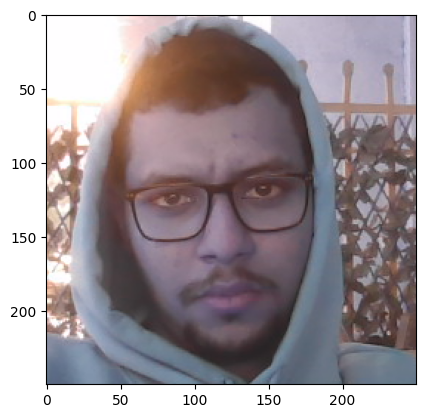

In [25]:
plt.imshow(frame)

Get Images from our Directory 

In [4]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [5]:
dir_test = anchor.as_numpy_iterator()

In [6]:
print(dir_test.next())

b'data\\anchor\\483b7096-a96a-11ee-895d-a8934a6f2abd.jpg'


Processing and Rescale

In [7]:
def preprocess(file_path):   
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100,100))
    img = img / 255.0
    return img

In [8]:
img = preprocess('C:\Users\adil-\OneDrive\Bureau\my_model\data\negative\Aaron_Peirsol_0001.jpg')

img.numpy().min()

0.09387255

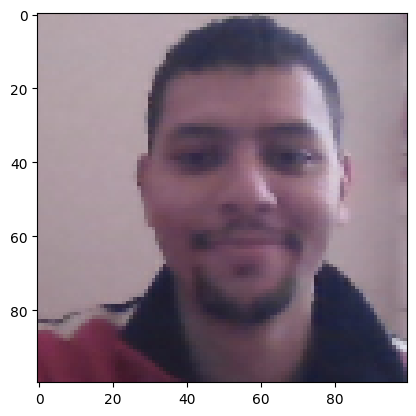

In [9]:
plt.imshow(img)

In [54]:
anchor.map(preprocess)
positive.map(preprocess)
negative.map(preprocess)

<_MapDataset element_spec=TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None)>

Create Labelled DataSet

In [17]:
tf.ones_like(1)

<tf.Tensor: shape=(), dtype=int32, numpy=1>

In [16]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [17]:
samples = data.as_numpy_iterator()

In [18]:
example = samples.next()

In [19]:
example

(b'data\\anchor\\b02eb365-a969-11ee-8c2a-a8934a6f2abd.jpg',
 b'data\\positive\\dd6b6362-a969-11ee-b1a4-a8934a6f2abd.jpg',
 1.0)

Build Train and Test Partition

In [8]:
def preprocess_twin(input_img,validation_img,label):
    return(preprocess(input_img),preprocess(validation_img),label)

In [20]:
res = preprocess_twin(*example)

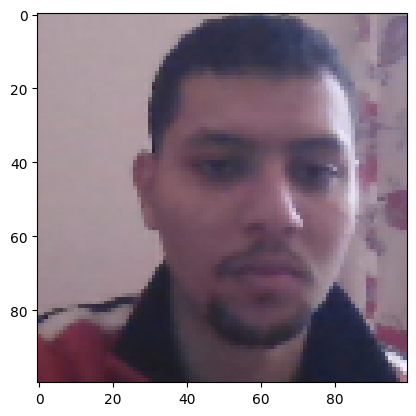

In [21]:
plt.imshow(res[1])

In [22]:
data = data.map(preprocess_twin)
data= data.cache()
data = data.shuffle(buffer_size=1024)

In [23]:
our_data = data.as_numpy_iterator()

In [24]:
len(our_data.next())

3

In [25]:
sample = our_data.next()

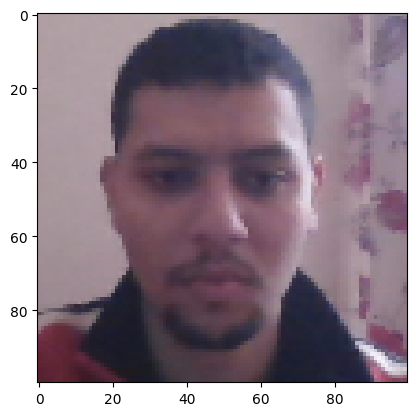

In [26]:
plt.imshow(sample[0])

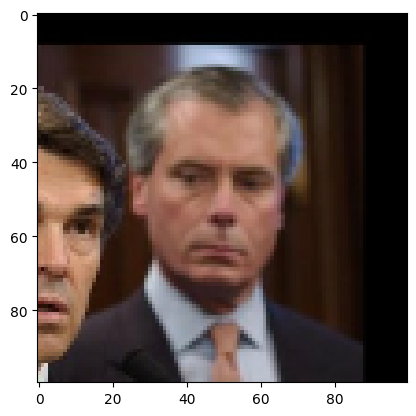

In [27]:
plt.imshow(sample[1])

In [28]:
sample[2]

0.0

In [29]:
#Training Data 
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [30]:
train_sample = train_data.as_numpy_iterator()

In [31]:
train_sample = train_sample.next()

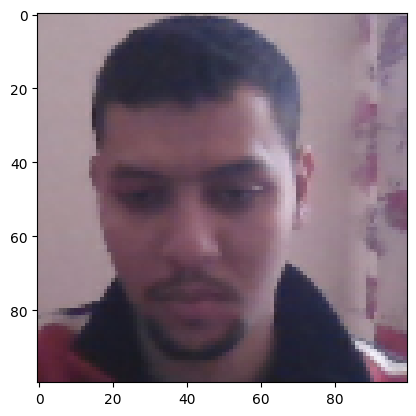

In [32]:
plt.imshow(train_sample[0][1])

In [33]:
#Testing Data
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

Model Creation 

In [71]:
def model_embedding():
    input_layer = Input(shape=(100,100,3))

    #First Blok of the Model
    c1 = Conv2D(64,(10,10),activation="relu")(input_layer)
    m1 = MaxPooling2D(64,(2,2),padding="same")(c1)

    #Second Block of the Model
    c2 = Conv2D(128,(7,7),activation="relu")(m1)
    m2 = MaxPooling2D(64,(2,2),padding="same")(c2)

    #Third Block of the Model
    c3 = Conv2D(128,(4,4),activation="relu")(m2)
    m3 = MaxPooling2D(64,(2,2),padding="same")(c3)

    #Final Block of the Model
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)

    return Model(inputs = [input_layer] ,outputs= [d1],name="embedding")

In [72]:
model = model_embedding()

In [73]:
model.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_3 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 17, 17, 128)       26

Create Distance Layer

In [3]:
class L1SiameseDist(Layer):
    def __init__(self,**kwargs):
        super().__init__()
    
    def call(self,input_embedding,validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [38]:
l1 = L1SiameseDist()

Make Siamese Model

In [36]:
def siamese_model():
    input_image = Input(shape=(100,100,3),name="input_image")
    validation_image = Input(shape=(100,100,3),name="validation_image")

    siamese_layer = L1SiameseDist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(model(input_image), model(validation_image))


    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [41]:
siamese_model=siamese_model()

AssertionError: Exception encountered when calling layer "SiameseNetwork" (type Functional).

Could not compute output KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_1/Sigmoid:0', description="created by layer 'dense_1'")

Call arguments received by layer "SiameseNetwork" (type Functional):
  • inputs=tf.Tensor(shape=(None, 100, 100, 3), dtype=float32)
  • training=None
  • mask=None

In [39]:
siamese_model.summary()

AttributeError: 'function' object has no attribute 'summary'

Training the Model

In [8]:
binary_cross_loss=tf.losses.BinaryCrossentropy()

In [9]:
optimizer=tf.keras.optimizers.Adam(1e-4)

Setting up the Checkpoints

In [97]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=optimizer, siamese_model=siamese_model)

Train Step Function

In [107]:
test_batch = train_data.as_numpy_iterator()

In [108]:
b1 = test_batch.next()

In [109]:
x=b1[:2]

In [110]:
x

(array([[[[0.68602943, 0.6193628 , 0.6507353 ],
          [0.6852941 , 0.62058824, 0.6509804 ],
          [0.68235296, 0.62352943, 0.64509803],
          ...,
          [0.60318625, 0.5531863 , 0.61691177],
          [0.59117645, 0.54044116, 0.60637254],
          [0.5661765 , 0.5230392 , 0.5879902 ]],
 
         [[0.6872549 , 0.62647057, 0.654902  ],
          [0.6870098 , 0.6262255 , 0.6512255 ],
          [0.68333334, 0.622549  , 0.6431373 ],
          ...,
          [0.44730392, 0.39338234, 0.4776961 ],
          [0.4745098 , 0.41764706, 0.5107843 ],
          [0.51936275, 0.4625    , 0.55563724]],
 
         [[0.6879902 , 0.6272059 , 0.6497549 ],
          [0.6870098 , 0.6247549 , 0.6460784 ],
          [0.6862745 , 0.61960787, 0.6431373 ],
          ...,
          [0.46715686, 0.40441176, 0.5110294 ],
          [0.46838236, 0.3990196 , 0.5129902 ],
          [0.44460785, 0.38186276, 0.49362746]],
 
         ...,
 
         [[0.34436274, 0.13259804, 0.19534314],
          [0.34338

In [111]:
y=b1[2]

In [112]:
y

array([1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1.],
      dtype=float32)

In [113]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:     
        x = batch[:2]
        y = batch[2]
        
        yhat = siamese_model(x, training=True)
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    optimizer.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    return loss


In [115]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        for idx, batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+1)
        
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [116]:
EPOCHS=50

In [117]:
train=train(train_data,EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
23/23 [==============================] - 53s 2s/step

 Epoch 2/50
23/23 [==============================] - 48s 2s/step

 Epoch 3/50
23/23 [==============================] - 51s 2s/step

 Epoch 4/50
23/23 [==============================] - 46s 2s/step

 Epoch 5/50
23/23 [==============================] - 48s 2s/step

 Epoch 6/50
23/23 [==============================] - 45s 2s/step

 Epoch 7/50
23/23 [==============================] - 47s 2s/step

 Epoch 8/50
23/23 [==============================] - 47s 2s/step

 Epoch 9/50
23/23 [==============================] - 50s 2s/step

 Epoch 10/50
23/23 [==============================] - 49s 2s/step

 Epoch 11/50
23/23 [==============================] - 49s 2s/step

 Epoch 12/50
23/23 [==============================] - 49s 2s/step

 Epoch 13/50
23/23 [==============================

Evaluate the Model

In [118]:
from tensorflow.keras.metrics import Precision, Recall

In [34]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [35]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

NameError: name 'siamese_model' is not defined

In [158]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1]

In [159]:
y_true

array([0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.],
      dtype=float32)

In [160]:
m = Recall()
m.update_state(y_true, y_hat)
m.result().numpy()

1.0

In [161]:
m = Precision()
m.update_state(y_true, y_hat)
m.result().numpy()

1.0

Visualize Results

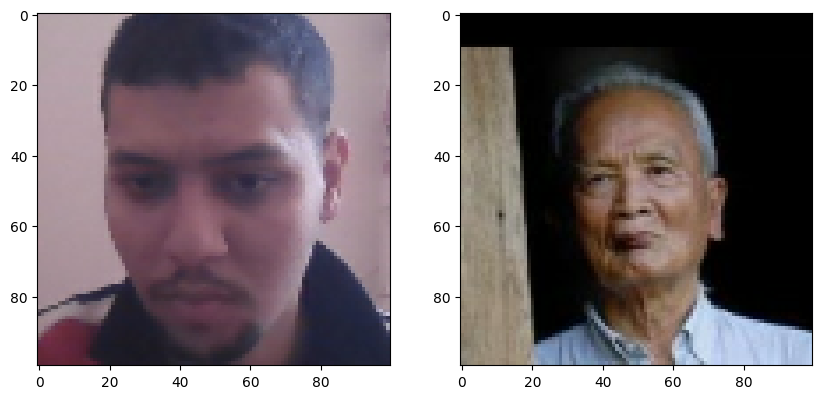

In [164]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(test_input[5])
plt.subplot(1,2,2)
plt.imshow(test_val[5])
plt.show()

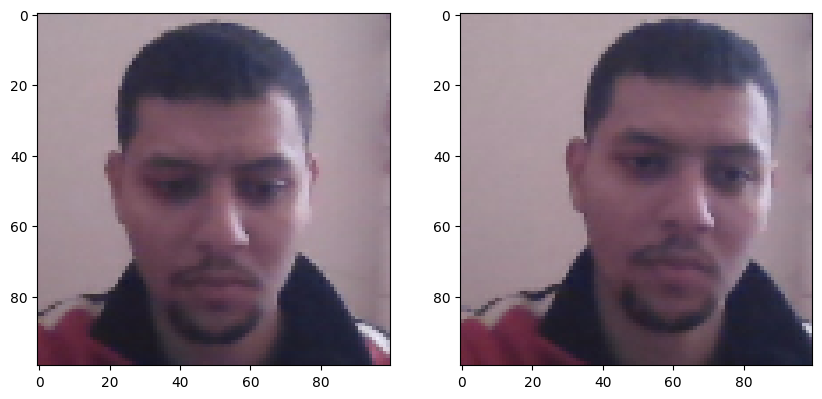

In [163]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(test_input[2])
plt.subplot(1,2,2)
plt.imshow(test_val[2])
plt.show()

Save the Model

In [142]:
siamese_model.save('FaceRecognitionModel.h5')

c:\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [4]:
model = tf.keras.models.load_model('FaceRecognitionModel.h5'
                                   ,custom_objects={'L1SiameseDist':L1SiameseDist,'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [42]:
model.predict([test_input,test_val])

1/1 [==============================] - 1s 645ms/step


array([[1.0000000e+00],
       [9.9999988e-01],
       [9.9977070e-01],
       [2.6051696e-09],
       [3.4690157e-09],
       [9.9196941e-01],
       [1.0000000e+00],
       [2.2652774e-08],
       [9.6231012e-10],
       [9.9999982e-01],
       [9.9999952e-01],
       [4.5558382e-10],
       [9.7367938e-06],
       [9.9919432e-01],
       [7.4740081e-10],
       [1.0000000e+00]], dtype=float32)

In [43]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_image (InputLay  [(None, 100, 100, 3)]        0         []                            
 er)                                                                                              
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_image[0][0]',         
                                                          8          'validation_image[0][0]']    
                                                                                     

Real Time WebCam Testing

In [44]:
def verify(model, detection_threshold, verification_threshold):
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))

        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)

    detection = np.sum(np.array(results) > detection_threshold)
    
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [46]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)

    if cv2.waitKey(10) & 0xFF == ord('v'):
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        results, verified = verify(model, 0.1, 0.1)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 80ms/step
False
1/1 [==============================] - 0s 80ms/step
False
